### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 3
### Due: Saturday, Feb 10th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.

4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [1]:
!pip install numdifftools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 1.7 MB/s eta 0:00:00a 0:00:01


In [3]:
import scipy.stats
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

1) Read in `hw3_data_1.npy`. This is a (50 x 2) numpy array, with measurements in the first column and uncertainties in the second column. Using the analytic results for heteroscedastic Gaussian data from lectures, compute the sample mean and the standard error on the sample mean from for this data.

In [8]:
arr = np.load('/home/rothj1/Desktop/AstroStats/repos/astr_8070_s24/coursework/homeworks/hw_data/hw3_data_1.npy')


In [18]:
print(arr)

[[2.97207735 0.93806458]
 [1.98824293 1.40262692]
 [1.66981961 1.97120698]
 [3.96519709 0.60359301]
 [3.38541476 1.29698654]
 [4.24894584 1.68629961]
 [3.69290063 1.06277049]
 [4.33198366 1.28038671]
 [2.49401178 1.22485083]
 [1.89419429 1.40555012]
 [2.04203146 1.30841409]
 [4.15394176 1.97421998]
 [4.14130534 1.59510787]
 [4.21256076 1.4295954 ]
 [4.47047556 0.9776734 ]
 [4.29385594 1.47949413]
 [3.68668822 0.96958318]
 [4.67658913 1.53171867]
 [3.66326255 0.51330266]
 [3.86702391 0.69561611]
 [4.15062285 0.76745015]
 [5.10972749 1.94193392]
 [4.16180633 1.26347131]
 [4.04294769 1.50713396]
 [3.14447868 1.51402808]
 [6.13017327 1.67982047]
 [7.47431877 1.79210525]
 [4.55226549 0.70417746]
 [3.18937552 1.41750426]
 [5.05068215 1.59340252]
 [2.58504832 1.40936962]
 [3.2807617  0.7817426 ]
 [3.15074159 0.5165563 ]
 [4.68488632 0.67327222]
 [6.58112816 1.91096086]
 [2.8891109  1.63403368]
 [5.12723698 0.58202125]
 [4.42150207 0.86437187]
 [5.78739811 1.1488919 ]
 [3.09099302 0.99063548]


For a heterscedastic Gaussian, we have from Lecture 5 that the MLE solution of the mean is 

$$\hat \mu = \frac{\sum_i^N (x_i/\sigma_i^2)}{\sum_i^N (1/\sigma_i^2)},$$

with the uncertainty of the mean being

$$\sigma_{\mu} = \left( \sum_{i=1}^N \frac{1}{\sigma_i^2}\right)^{-1/2}.$$

So we can iterate through the first column to compute the sample mean and iterate through the second to get the standard error of the mean analytically. 

In [16]:
numers = []
denoms = []
sigmas = []

for i in range(len(arr[:,0])):
    xi = arr[i,0]
    sigi = arr[i,1]

    numer = xi/(sigi**2)
    numers.append(numer)

    denom = 1/(sigi**2)
    denoms.append(denom)

    sigmas.append(1/(sigi**2))

muHat = np.sum(numers) / np.sum(denoms)
sigMu = (np.sum(sigmas))**(-1/2)

print(muHat,sigMu)


3.9179920346060557 0.09481084100510954


2) Reusing some approaches and tools from `Lecture_6`, write a ln-likelihood function for heteroscedastic Gaussian data, and use it in a fitting algorithm to find the best-fit mean. *Remember that scipy optimizers are set up to minimize functions.*

From Lecture 5, we have the definition of the log-likelihood function as

$$\ln L = {\rm constant} - \sum_{i=1}^N \frac{(x_i - \mu)^2}{2\sigma_i^2}.$$



In [35]:
def ln_likelihood(data,testMu,const=0):
    # function to get the ln likelihood of values for heteroscedastic gaussian data
    xvals = data[:,0] # grab first col
    sigmavals = data[:,1] # grab second col
    frac = np.sum(((xvals-testMu)**2)/(2*(sigmavals**2))) # Ryan reminded me I could sum a whole col in one step
    lnlike = const - frac
    return lnlike

In [36]:
ln_likelihood(data=arr,testMu=3)

-90.03652553954079

We want to test a variety of different mu values to see which one maximizes the lnL for this dataset.

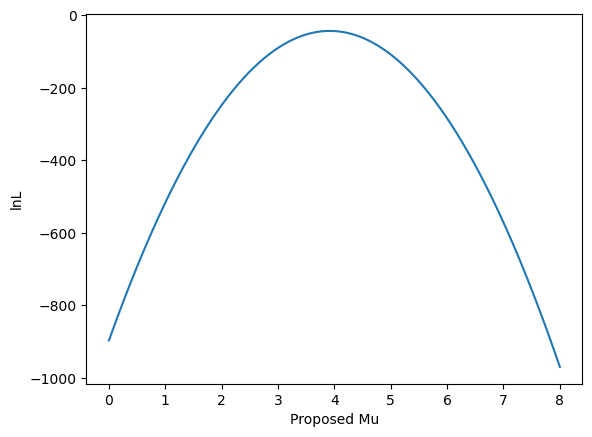

In [49]:
muGrid = np.linspace(0,8,1000)
lnLs = []
for elem in muGrid: # was having problems plotting the function itself across muGrid so decided to loop instead
    lnLval = ln_likelihood(data=arr,testMu=elem)
    lnLs.append(lnLval)

plt.plot(muGrid,lnLs);
plt.ylabel('lnL');
plt.xlabel('Proposed Mu');

Looks like the best mu value is around 4, but we can find the exact value.

In [48]:
lnLmax = max(lnLs)
print(lnLmax)

# Since lnLs and muGrid are the same length and ordered, we can find the index of the max lnL and locate that way
best_index = lnLs.index(lnLmax)
best_mu = muGrid[best_index]
print(best_mu)

-43.162785096327205
3.915915915915916


This best mu value matches pretty well with the analytical value we found above. There probably is a more elegant way of doing this, with scipy optimizers (?) and NumPy arrays but this was the easiest way for me.

3) Using the same numerical technique from `Lecture_5`, compute the Fisher uncertainty estimate on the mean.


In [52]:
sigma_mu = np.diff(lnLs, n=2) #2nd order deriv
sigma_mu /= (muGrid[1]-muGrid[0])**2 # sigma_mu = sigma_mu / ... --> Divide by delta theta^2
sigma_mu *= -1 # sigma_mu = sigma_mu * ... subtract 1
sigma_mu = 1/np.sqrt(sigma_mu)[0]
print('Fisher uncertainty on the mean is',sigma_mu)

Fisher uncertainty on the mean is 0.09481084100389774


4) Using the bootstrap method, generate $1000$ bootstrap realizations of this dataset. *DO NOT use the `astroML` code. Write your own bootstrap function from scratch. Also recall that when resampling data, measurements and uncertainties should stay paired together.*

1000 different boostrap realizations means creating 1000 new 50x2 arrays where each row is randomly selected from the original 50x2 array, and it is okay if a row is selected more than once or not at all in the same array. We can psuedo-randomly select rows from the original array to form rows in the new array, then repeat 999 more times.

In [63]:
np.random.seed(21023) # for testing solutions with Ryan
import random

def newRow(arr):
    index = random.randrange(50)
    newRow = arr[index,:] # grabbing both cols for a specific row
    return newRow

newArr = np.zeros((50,2))
print(len(newArr))
newArr[0,:] # can select a full row using [0] or [0:,]

50


array([0., 0.])

In [85]:
def bootOneArr(arr): 
    # get one new bootstrapped array
    newArr = np.zeros((50,2))
    for row_idx in range(len(newArr)): # for 50 iterations
        newArr[row_idx] = newRow(arr) # rewrite newRow to be the newRow result
    return newArr

allBoots = [] # list that will store my 2d arrays
for i in range(1000): # 1000 times
    bootResult = bootOneArr(arr)
    allBoots.append(bootResult)

print(len(allBoots))
print(len(allBoots[0]))
print(len(allBoots[0][0]))
print('Yay!')

1000
50
2
Yay!


5) Repeat (2) with all $1000$ boostrap datasets to find the distribution of the sample mean. Plot a normalized histogram of these bootstrap means, and overplot a Gaussian pdf with the mean and std found in (1). Do these agree?


Step 2 was plotting the ln-likelihood over a variety of proposed mu values and locating mu that maximized the lnL for that dataset. Now, we can run it over 1000 datasets, which will provide 1000 different mu values, which we can then plot (should be normally distributed). 

I should automate the process from step 2 into one larger function that returns the mean for one plot, then i can call that function 1000 times. 

In [87]:
# ln_likelihood(data,testMu) returns one lnL for one testMu
# muGrid = np.linspace(0,8,1000)

def getBestMu(data):

    lnLs = []
    for elem in muGrid:
        lnLval = ln_likelihood(data,testMu=elem)
        lnLs.append(lnLval)
    
    lnLmax = max(lnLs)
    best_index = lnLs.index(lnLmax)
    best_mu = muGrid[best_index]

    return best_mu

In [92]:
bestMus = []
for i in range(len(allBoots)): # 1000 iterations
    bestMuVal = getBestMu(data=allBoots[i])
    bestMus.append(bestMuVal)

In [98]:
print(len(bestMus))
print(bestMus) # these should vary
print('Looking good so far...')

1000
[4.084084084084084, 3.971971971971972, 4.14014014014014, 4.228228228228228, 4.156156156156156, 4.06006006006006, 3.9079079079079078, 3.883883883883884, 3.8918918918918917, 4.02002002002002, 3.963963963963964, 4.004004004004004, 4.22022022022022, 4.188188188188188, 3.9319319319319317, 3.8118118118118116, 4.156156156156156, 3.8918918918918917, 4.076076076076076, 4.292292292292292, 4.236236236236236, 3.963963963963964, 3.8918918918918917, 4.2842842842842845, 3.7477477477477477, 3.8998998998999, 4.06006006006006, 3.955955955955956, 4.06006006006006, 3.6676676676676676, 3.8998998998999, 4.1641641641641645, 4.02002002002002, 4.06006006006006, 4.132132132132132, 4.228228228228228, 4.012012012012012, 3.8678678678678677, 3.947947947947948, 4.028028028028028, 4.212212212212212, 3.843843843843844, 3.971971971971972, 4.044044044044044, 4.02002002002002, 4.132132132132132, 3.9319319319319317, 3.97997997997998, 4.212212212212212, 4.188188188188188, 4.2842842842842845, 4.156156156156156, 4.01201

3.9179920346060557 0.09481084100510954


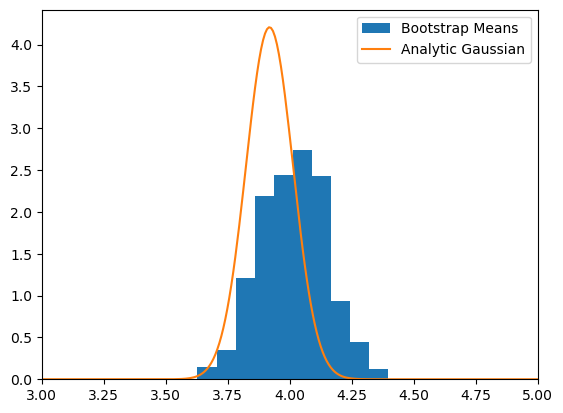

In [134]:
# plot a normalized histogram of these best mu values and overlay a gaussian
plt.hist(bestMus,bins=10,density=True,label='Bootstrap Means');

print(muHat,sigMu) # Analytic results from problem 1
gaussAnalytic = norm(muHat,sigMu)

plt.plot(muGrid,gaussAnalytic.pdf(muGrid),label='Analytic Gaussian')
plt.xlim(3,5);
plt.legend();

These are relatively similar in their shape (gaussian) and scales but their means and peak values are slightly off. I am not sure why because 1000 bootstrap samples should be enough to reconstruct the analytical curve.

6) While we have fitted a heteroscedastic Gaussian to this data, let's try something else. Write some code to define a ln-likelihood for a Laplace distribution evaluated on this data. Fit simultaneously for the Laplace location parameter $\mu$ and scale parameter $\Delta$.

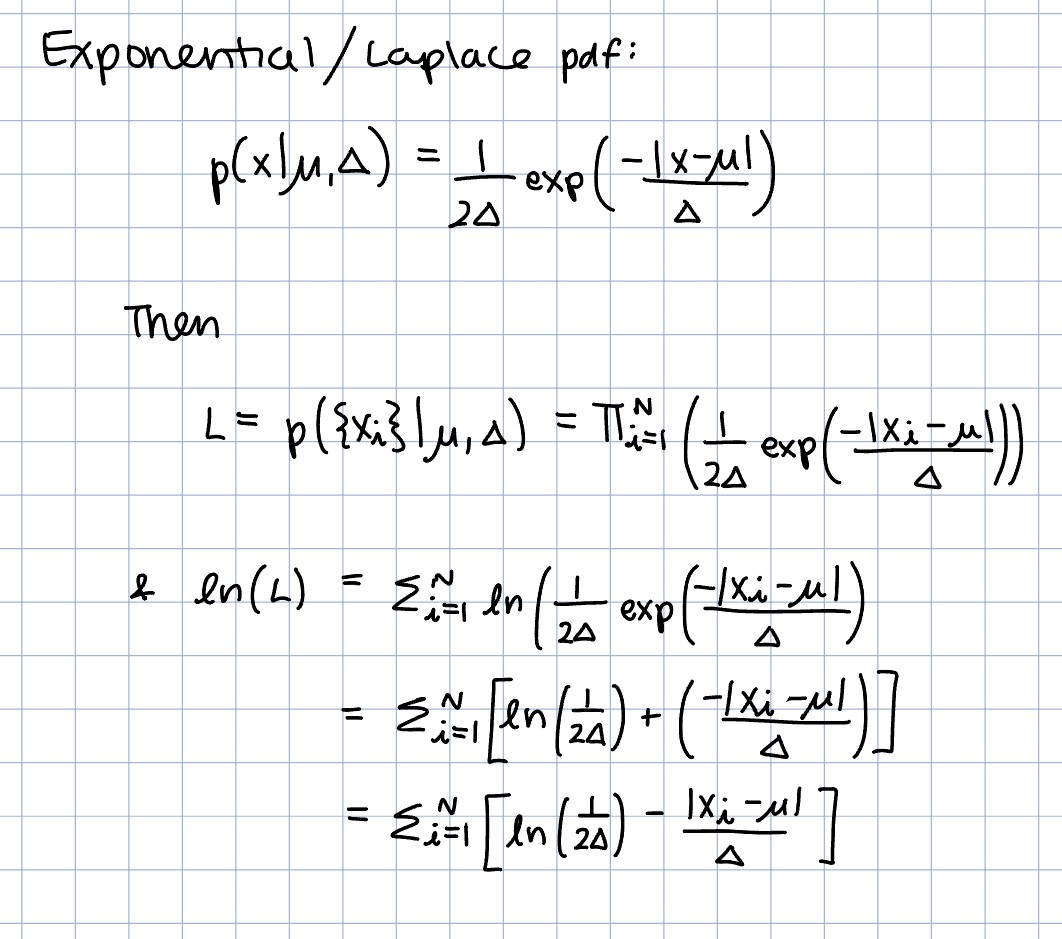
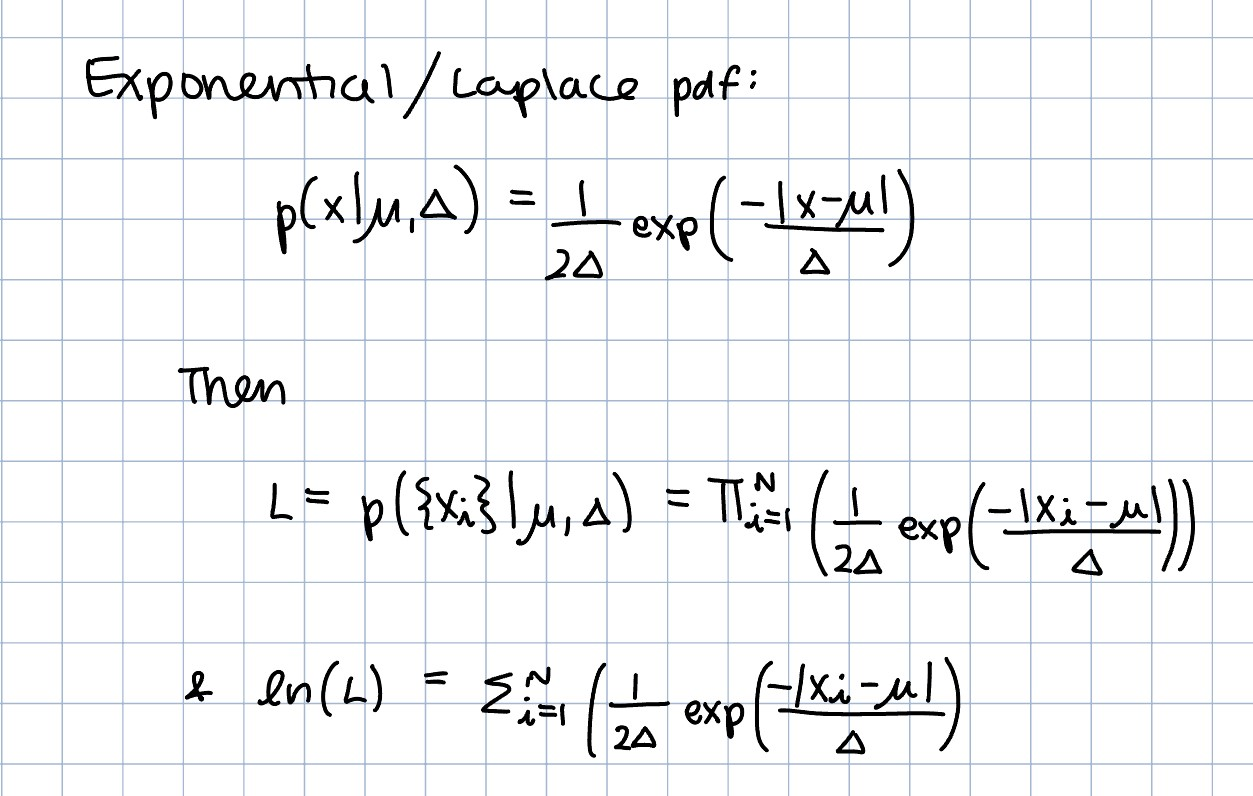

In [221]:
def lnL_laplace(data,testMu,testDelta):
    xvals = data[:,0]
    sigmavals = data[:,1]

    const = np.log(1/(2*testDelta))
    frac = abs(xvals-testMu)/testDelta
    
    lnL_lap = np.sum(const - frac)

    return lnL_lap # returns one value for a given testMu and testDelta

In [244]:
# Don't bootstrap yet, just get one mu and delta that maximize lnL given the original data (arr)

muGrid2 = np.linspace(2,6,100)
delGrid = np.linspace(0.001,2,100)

def getBestparams_lap(data):

    # since we need every combo of mu and delta, not just going in order through linspace, need better indexing method
    storage = []

    # nested for loop to test all combos of mu and delta
    for m in range(len(muGrid2)):
        for d in range(len(delGrid)):
            lnLval = lnL_laplace(data=arr,testMu=muGrid2[m],testDelta=delGrid[d])
            temp = [muGrid2[m],delGrid[d],lnLval]
            storage.append(temp)

    lnLs = storage[:][2] # grabbing only 3rd column (have to slice this way with lists)

    # Now back to method from before
    lnLmax = max(lnLs)
    best_index = lnLs.index(lnLmax)
    best_mu_lap = muGrid2[best_index]
    best_del_lap = delGrid[best_index]

    return best_mu_lap,best_del_lap,lnLmax

In [245]:
best_mu_arr, best_del_arr, maxLnL_lap = getBestparams_lap(arr)
print(best_mu_arr, best_del_arr,maxLnL_lap)

2.0 0.001 2.0


The best mu and delta that keep returning are the lowest ones I allow, and they change each time I change linspace, so I know that these are not actually the optimal parameters for the laplace model. I tried to keep a similar method to what I did with a gaussian, because it logically made sense to me, but maybe that was the mistake. Nested for loops take a lot of time and lists are hard to index correctly. I would expect a mean closer to 4 and a delta closer to 1, because the laplace distribution looks sort of like a pointy gaussian, so it wouldn't do a horrible job at modelling the histogram from before.

7) Compute the AIC values for the heteroscedastic Gaussian model and the Laplacian model. Which model is favored by the data?

The AIC measures goodness of fit to a model and, from Lecture 6, is given by

$$ \mathrm{AIC}_M \equiv -2\ln[L^0(M)] + 2k + \frac{2k(k+1)}{N-k-1} $$

where $L^0(M)$ is the maximum likelihood given the model. 


In [247]:
# k = number of params in model = 2 for laplace, 1 for gaussian
# N = 50 for both (or 1000?)

# for the gaussian, I'm going to choose the initial best mu I found rather than the mean of all mus from bootstrapping

AIC_lap = -2*maxLnL_lap + 2*2 + (2*2*3)/(50-2-1)
AIC_gauss = -2*lnLmax + 2*1 + (2*1*2)/(50-1-1)

print(AIC_lap,AIC_gauss)

0.2553191489361702 88.40890352598774


Given that it has the lowest AIC, the laplace model would be a better fit. Since I don't trust the laplace mu and delta I got, I don't think this AIC is the case, plus it would make more sense for the gaussian to be a better fit given how the histogram looked. 

8) Using the $1000$ bootstrap datasets from before, fit for the Laplacian $\mu$ and $\Delta$ for each. Make a nice `corner` plot of the distributions of $\mu$ and $\Delta$ that shows both the marginal $1$D distributions and the joint $2$D distribution. Make sure the plot has labels, shows the titles on each $1$D marginal panel, and has $68\%$ and $95\%$ levels.

In [249]:
bestMus_lap = []
bestDels_lap = []

for i in range(1000):
    best_mu, best_del, maxL = getBestparams_lap(data=allBoots[i])
    bestMus_lap.append(best_mu)
    bestDels_lap.append(best_del)

bestMus_lap_np = np.array(bestMus_lap)
bestDels_lap_np = np.array(bestDels_lap)

Obviously, each mean should not be exactly the same. Clearly something is wrong with my getParams function. 

[[2.e+00 2.e+00]
 [2.e+00 2.e+00]
 [2.e+00 2.e+00]
 ...
 [1.e-03 1.e-03]
 [1.e-03 1.e-03]
 [1.e-03 1.e-03]]


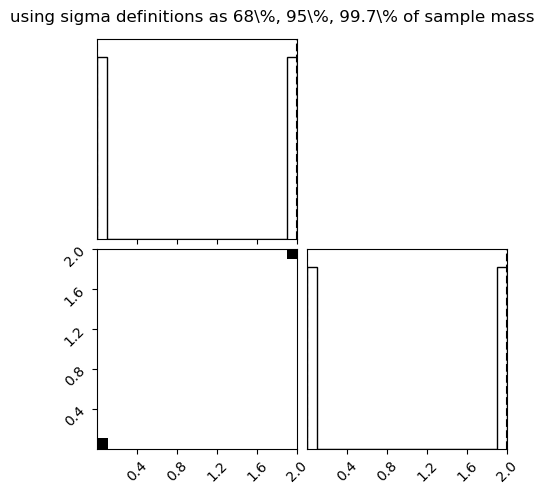

In [262]:
import corner
best_vals = np.vstack([bestMus_lap_np,bestDels_lap_np]) # stack to feed to corner.corner
best_vals = best_vals.reshape([1000,2])
print(best_vals)

# from Lecture 4:
# standard sample mass definition (1 sigma encompasses 68%)
fig = corner.corner(best_vals, quantiles=(0.16, 0.84), levels=(0.68,0.95,0.997))
fig.suptitle("using sigma definitions as 68\%, 95\%, 99.7\% of sample mass");

So, this type of corner plot is supposed to show the spread of each dimension (here, would be the spread of mus and the spread of deltas except there are none because mine are all the same value). Then, over the same range of points, the "amplitude" at those points would "sum" together, and the highest sum would create the darkest points. Then, it would be relatively easy to see where the peak in both of the distributions is. We wouldn't get an exact peak value, but we could use contours to give us intervals of high confidence. Sadly, can't visualize this with the coding issues I'm having, though I feel confident in my logic for each step since it worked out well enough for the gaussian. 

9) Let's finish with a Fisher uncertainty estimate of the Laplacian parameters. Use the following code to install `numdifftools` which provides a simple way to compute derivatives. We can then compute the Hessian matrix, which is the matrix of the second derivatives of the user's function. This should be computed at the best-fit Laplacian parameters $\mu$ and $\Delta$. To finish, invert the matrix, and then take the square root. The diagonal entries will then be the Fisher uncertainties on $\mu$ and $\Delta$. How does these compare to the bootstrap distribution widths found in (8)?

In [270]:
import numdifftools as nd

#H = nd.Hessian(f_lnlaplace)([beta_laplace[0], beta_laplace[1]])
H = nd.Hessian(lnL_laplace(arr,muGrid2,delGrid)) # take first elem bc why not, they are all same 

sigma_laplace = np.linalg.inv(H)**0.5

LinAlgError: 0-dimensional array given. Array must be at least two-dimensional

Apologies for the lack of completeness. In the hessian documentation it appears to want a function as its input, but it's possible that the types of functions I wrote aren't compatible (amount of objects returned, etc). More likely, it's that I am not understanding what the Hessian function does with what its given, and also my functions are not providing me the correct values for the laplace case anyways (sigh). I imagine that the diagonal of the hessian, if meant to be the fisher uncertainties on mu and delta, would be similar to the bootstrap distribution widths from the corner plot in 8 given that 1000 bootstrap realizations should definitely be enough to get an accurate sampling and estimate of the true spread of the values. 